# DB backends experiments

## Description

Several experimetns on GO DB backends were performed in order to measure disk usage and operation times. 

## Util functions

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import re
import os

In [67]:
class Step:
    def __init__(self, name, du, records, duration):
        self.name = name
        self.du = du
        self.records = records
        self.duration = duration
        
    def __str__(self):
        return f"Step({self.name}, {self.du}, {self.n_records}, {self.duration})"
    
    def __repr__(self):
        return f"Step({self.name}, {self.du}, {self.n_records}, {self.duration})"
    
    def parse_from_tokens(tokens):
        if len(tokens) != 5:
            raise Exception("Incorrect line")
        name = tokens[1]
        du = int(tokens[2])
        records = int(tokens[3])
        duration = Step.parse_duration(tokens[4])
        return Step(name, du, records, duration)
        
    def parse_duration(s):
        if s[-1] == '}':
            s = s[:-1]
        tokens = re.split('h|m|s|\.', s)
        if 'h' in s:
            hours = int(tokens[0])
            mins = int(tokens[1])
            secs = int(tokens[2])
            return 3600 * hours + 60 * mins + secs
        elif 'm' in s:
            mins = int(tokens[0])
            secs = int(tokens[1])
            return 60 * mins + secs
        else:
            if 's' not in s:
                raise Exception("Bad time format")
            secs = int(tokens[0])
            return secs
        
    def parse_from_file(file_path):
        steps = []
        with open(file_path) as f:
            for ln in f.readlines():
                tokens = ln.strip().split()
                if len(tokens) == 0:
                    continue
                if tokens[0] == '{':
                    steps.append(Step.parse_from_tokens(tokens))
        return steps

In [122]:
def draw_experiment(experiment_name):
    measurementsDIR = "measurements"
    files = [f for f in os.listdir(measurementsDIR) if os.path.isfile(os.path.join(measurementsDIR, f))]
    files = list(filter(lambda f: f.startswith(experiment_name), files))
    n = len(files)
    
    fig, axs = plt.subplots(n, 3, figsize=(15, 4 * n))
    
    for i, file in enumerate(files):
        backend = re.split('_|\.', file)[1]
        steps = Step.parse_from_file(os.path.join(measurementsDIR, file))
        draw_steps(axs[i], steps, backend)
        
    plt.tight_layout()
    plt.show()
        

def draw_steps(ax, steps, backend):
    durations = [step.duration for step in steps]
    dus = [step.du for step in steps]
    records = [step.records for step in steps]
    x = [i for i in range(len(steps))]
    
    ax[0].text(-0.5, 0.5, backend, transform=ax[0].transAxes, va="center", fontsize=18)
    
    ax[0].plot(x, durations) 
    ax[0].set_xticks(x)
    ax[0].set_xlabel("Steps")
    ax[0].set_ylabel("Durations")
    
    ax[1].plot(x, dus) 
    ax[1].set_xticks(x)
    ax[1].set_xlabel("Steps")
    ax[1].set_ylabel("Disk usage MiB")
    
    ax[2].plot(x, records) 
    ax[2].set_xticks(x)
    ax[2].set_xlabel("Steps")
    ax[2].set_ylabel("Records")

## Experiments

### Small inserts
In this experiment we perform simple inserts to DB. 
 * Key size: 64B
 * Value size: 1MiB
 * Volume per step: 1GiB
 * Total storage goal: 10GiB

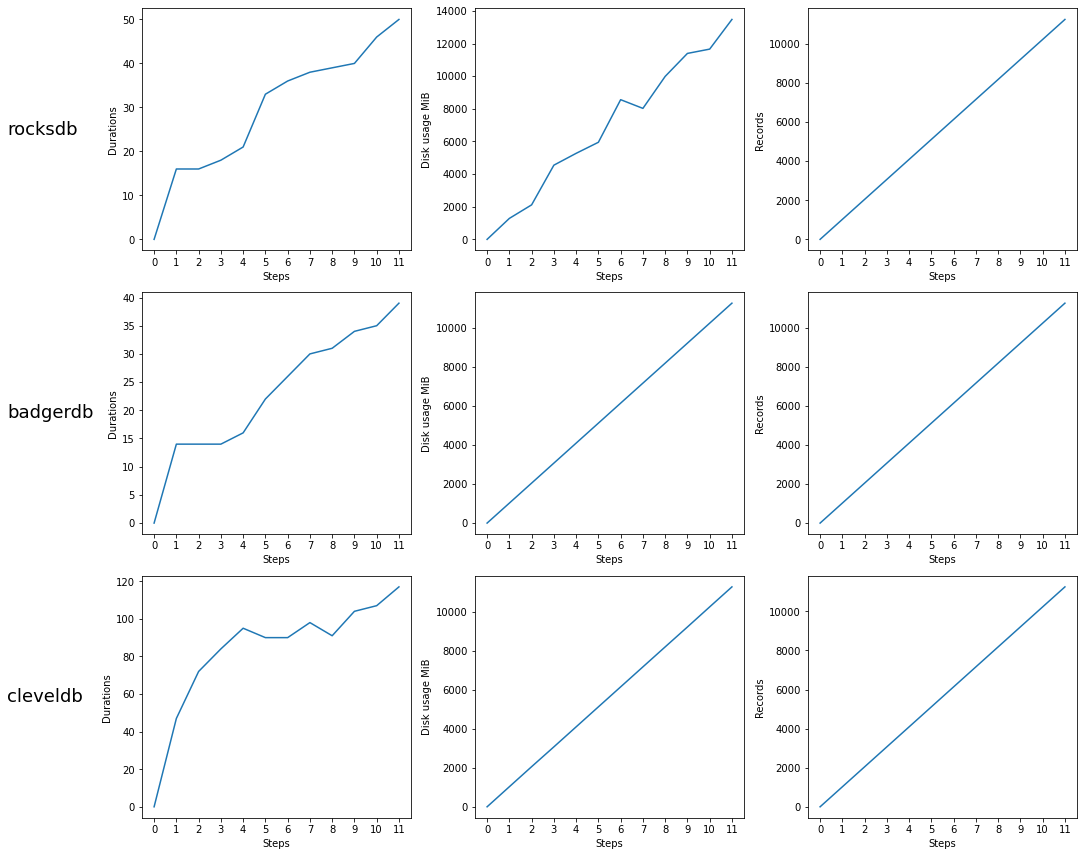

In [123]:
draw_experiment("BenchmarkSmallInserts")